This is the code for a 2D particle-in-cell plasma simulation. The electric field is computed at each time step by solving the poisson equation with a FFT using the charge density on a grid given by the distribution of particle positions on a grid. 

The particles are initially distributed in two overlapping (red and blue) beams with velocities in the x and -x directions. Gaussian noise is introduced in both the initial positions and initial velocities, while a slight sinusoidal perturbation is introduced in the velocity of one of the beams.
Two-stream instability is seen when plotting the position vs velocity in the direction, which is done in the main program loop below. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy



#function which calculates electric potential from charge density using FFT
def phi_compute(rho,eps0,Nx,Ny,dx,dy):
    kx = 2*np.pi*scipy.fft.fftfreq(Nx, d=dx)
    ky = 2*np.pi*scipy.fft.fftfreq(Ny, d=dy)
    
    #calculate fft of charge density
    rhok = scipy.fft.fft2(rho, workers = 8)
    phik = np.zeros((Nx,Ny), dtype = np.complex_)
    
    #calculate fourier transform of electric potential
    for i in range(Nx):
        for j in range(Ny):
            if kx[i] == 0 and ky[j] == 0:
                phik[i,j] = 0
            else:
                phik[i,j] = -rhok[i,j]/(kx[i]**2 + ky[j]**2)
                
    phik = 1 / eps0 * phik 
    phi = np.real(scipy.fft.ifft2(phik, workers = 8)) 

    return phi

#function which interatively calculates electric potential from charge density using finite differencing
def phi_solve(f, rho, h, stepper, atol=1.E-6, max_steps=10**5):
    for _ in range(max_steps):
        f_new = stepper(f, rho, h)
        if np.max(np.abs(f_new - f)) < atol:
            return f_new
        f = f_new
    return f

#function which performs one finite difference step
def roll_step(f, rho, h):
    f_new = 0.25 * (np.roll(f, 1, axis = 0) + np.roll(f, -1, axis = 0) + np.roll(f, 1, axis = 1) + np.roll(f, -1, axis = 1)) - 0.25 * h**2 * rho
    return f_new
    
#function which calculates acceleration of each particle 
def getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N):
    eps0 = 1
    dx = Lx/Nx
    dy = Ly/Ny
    j = np.zeros((N,2))
    jp1 = np.zeros((N,2))
    
    #define grid points
    j[:,0] = np.floor(pos[:,0]/dx).astype(int)
    j[:,1] = np.floor(pos[:,1]/dy).astype(int)
    jp1 = j + 1
    
    #calculate weights of particle on each grid point
    weight_jxjy = (jp1[:,0]*dx - pos[:,0])/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxp1jy = (pos[:,0] - j[:,0]*dx)/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxjyp1 = (jp1[:,0]*dx - pos[:,0])/dx * (pos[:,1] - j[:,1]*dy)/dy
    weight_jxp1jyp1 = (pos[:,0] - j[:,0]*dx)/dx * (pos[:,1] - j[:,1]*dy)/dy
    
    #periodic boundary conditions:
    jp1[:,0] = np.mod(jp1[:,0], Nx)
    jp1[:,1] = np.mod(jp1[:,1], Ny)
    
    #smear the particle position across four nearest gridpoints, weighting by distance to each gridpoint 
    xbin = np.linspace(0, Nx, Nx+1)
    ybin = np.linspace(0, Ny, Ny+1)
    
    #count number of particles smeared to each grid point
    n = st.binned_statistic_2d(j[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j) grid point
    n += st.binned_statistic_2d(jp1[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j+1) grid point
    n += st.binned_statistic_2d(j[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j+1) grid point
    n += st.binned_statistic_2d(jp1[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j) grid point
    
    #weight the contribution  of each particle to each grid point it has been smeared across
    n[j[:,0].astype(int),j[:,1].astype(int)] *= weight_jxjy
    n[jp1[:,0].astype(int),j[:,1].astype(int)] *= weight_jxp1jy
    n[j[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxjyp1
    n[jp1[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxp1jyp1
    
    #calculate charge density from particle weights
    rho = n0*n*Lx*Ly/N/(dx*dy)
    
    #calculate electric potential at each grid point
    phi_grid = phi_compute(rho,eps0,Nx,Ny,dx,dy)
    #f = np.zeros((Nx,Ny))
    #phi_grid = phi_solve(f, rho, dx, roll_step, atol=1.E-6, max_steps=10**5)
    
    #calculate electric field from electric potential
    Ex = -np.gradient(phi_grid, dx, axis = 0)
    Ey = -np.gradient(phi_grid, dy, axis = 1)
    E = np.zeros((N,2))
    j = j.astype(int)
    jp1 = jp1.astype(int)
    
    #interpolate electric field at each particle position
    E[:,0] = Ex[j[:,0],j[:,1]]*weight_jxjy + Ex[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ex[jp1[:,0],j[:,1]]*weight_jxp1jy + Ex[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    E[:,1] = Ey[j[:,0],j[:,1]]*weight_jxjy + Ey[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ey[jp1[:,0],j[:,1]]*weight_jxp1jy + Ey[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    a = -E
    
    return a

    
    
    
    

The above cell contains the function which solves the poisson equation at each time step and the function that calculates
the accleration of each particle at each time step. Both the FFT (`phi_compute`) and finite differencing (`phi_solve`) functions are present, though by default only the `phi_compute` function is used in the `getAccel` function.

The format of the `getAccel` and `main` functions are largely inspired by the code written by 
Philip Mocz (2020) Princeton Univeristy, @PMocz in his Create Your Own Plasma PIC Simulation (With Python)
https://github.com/pmocz/pic-python/blob/master/pic.py
The `phi_solve` function is taken from a Mathcube article and given in 
https://gist.github.com/mathcube7/fc33438a8b10af0100bcde9858d1f239#file-poisson-1-py

In [6]:


def main():
    N = 4*10**4         # number of particles
    Nx = 128            # grid points in x direction
    Ny = 128            # grid points in y direction
    Lx = 10             # grid length in x direction
    Ly = 10             # grid length in y direction
    dx = Lx/Nx          # grid spacing in x direction
    dy = Ly/Ny          # grid spacing in y direction
    t = 0               # initial time
    tEnd = 10           # total time
    dt = 0.1            # time step size
    n0 = 100            # specific weight of each particle
    vb        = 1.5       # beam velocity
    vth       = 1       # beam width
    A         = 0.1     # perturbation when including sinusoidal perturbation
    plotRealTime = True # switch on for plotting as the simulation goes along
        
    
    #initial positions of particles, organized with gaussian noise into two beams
    pos = np.zeros((N,2))
    pos[:np.floor(N/2).astype(int),1] = np.mod(5*Ly/10 + 0.05 * np.random.randn(np.floor(N/2).astype(int)), Ly)
    pos[np.floor(N/2).astype(int):,1] = np.mod(5*Ly/10 + 0.05 * np.random.randn(np.floor(N/2).astype(int)), Ly)
    #pos[:,1] = Ly/2
    pos[:,0] = np.random.uniform(0,Lx, size = N)
    
    #initial velocity of each particle, organized with gaussian noise into two beams
    vel = np.zeros((N,2))
    vel[:np.floor(N/2).astype(int),0]  = vth * np.random.randn(np.floor(N/2).astype(int)) + 0.25*vb
    vel[np.floor(N/2).astype(int):,0]  = -vth * np.random.randn(np.floor(N/2).astype(int)) - vb

    #sinusoidal perturbation to initial velocity
    vel[:,0] *= (1 + A*np.sin(2*np.pi*pos[:,0]/Lx))
        
    #calculate inital acceleration
    acc = getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N)
    
    #calculate new positions and velocities for each time step using leapfrog method
    Nt = int(np.ceil(tEnd/dt))
    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift (and apply periodic boundary conditions)
        pos += vel * dt
        pos[:,0] = np.mod(pos[:,0], Lx)
        pos[:,1] = np.mod(pos[:,1], Ly)


        # update accelerations
        acc = getAccel(pos,Nx,Ny,Lx,Ly,dt,n0,N)
        
        # (1/2) kick
        vel += acc * dt/2.0

        # update time
        t += dt
        
        %matplotlib
        # plot in real time - color 1/2 particles blue, other half red
        if plotRealTime or (i == Nt-1):
            plt.cla()
            
            #these two lines plot x vs y
            #plt.scatter(pos[:np.floor(N/2).astype(int),0],pos[:np.floor(N/2).astype(int),1],s=.4,color='blue', alpha=0.5)
            #plt.scatter(pos[np.floor(N/2).astype(int):,0],pos[np.floor(N/2).astype(int):,1],s=.4,color='red', alpha=0.5)
            
            #these two lines plot x vs v_x
            plt.scatter(pos[:np.floor(N/2).astype(int),0],vel[:np.floor(N/2).astype(int),0],s=.4,color='blue', alpha=0.5)
            plt.scatter(pos[np.floor(N/2).astype(int):,0],vel[np.floor(N/2).astype(int):,0],s=.4,color='red', alpha=0.5)
            
            plt.axis([0,Lx,-Ly,Ly])
            plt.pause(0.001)
            
    # Save figure
    plt.xlabel('$x$')
    plt.ylabel('$V_x$')
    plt.savefig('xy_pic_structure.png',dpi=600)
    plt.show()
    
    return 0



The above cell contains the main function where the main loop of the simulation occurs, updating the position and velocity of
each particle at each time step using the leapfrog method. By default the plot of position vs velocity in the x direction is output at each time step.

The following cell runs the main program, and also times how long the entire main program takes to run.

In [7]:
import time

start = time.time()
if __name__== "__main__":
  main()
end = time.time() - start

print('time taken = ', end, 's')

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg
Using ma

In [8]:

Nx = 128
Ny = 128
Lx = 10**2
Ly = 10**2
N = 10**2
q = 1
m = 1
eps0 = 1
dx = Lx/Nx
dy = Ly/Ny
rho = np.zeros((Nx,Ny))
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
t = 0.05

#function which calculates a 2D gaussian charge density with variance t
def gaussian2d(Nx, Ny, x, y, t):
    g = np.zeros((Nx,Ny))
    for i in range(Nx):
        for j in range(Ny):
            g[i,j] = np.exp(-((x[i]-30)**2 + (y[j]-50)**2)/(2*t)) / (4*np.pi*t)
    return g

#2 dimensional gaussian charge distribution 
rho2d = gaussian2d(Nx, Ny, x , y, t)

#compute and measure time taken to solve poisson equation using FFT
fft_start = time.time()
phitest2d=phi_compute(rho2d,eps0,Nx,Ny,dx,dy)
fft_end = time.time()-fft_start
print("The FFT time to solve poisson equation =", fft_end, "s")

#compute and measure time taken to solve poisson equation using finite difference
phi_init = np.zeros((Nx,Ny))
diff_start = time.time()
gauss2d_solve = phi_solve(phi_init, rho2d, dx, roll_step, atol=1.E-6, max_steps=10**5)
diff_end = time.time() - diff_start

print("The finite difference time to solve poisson equation =", diff_end, "s")
print("The finite difference method implemented is", diff_end/fft_end, "times slower than FFT.")



The FFT time to solve poisson equation = 0.017868995666503906 s
The finite difference time to solve poisson equation = 16.282619953155518 s
The finite difference method implemented is 911.2218871751081 times slower than FFT.


The above cell compares the time taken to solve the 2D poisson equation using FFT and finite differencing methods.

The following cell compares the electric potential calculated using FFT performed on a single particle on a particle-in-cell grid against the electric potential calculated using the analytic 1/r potential of a single particle. 


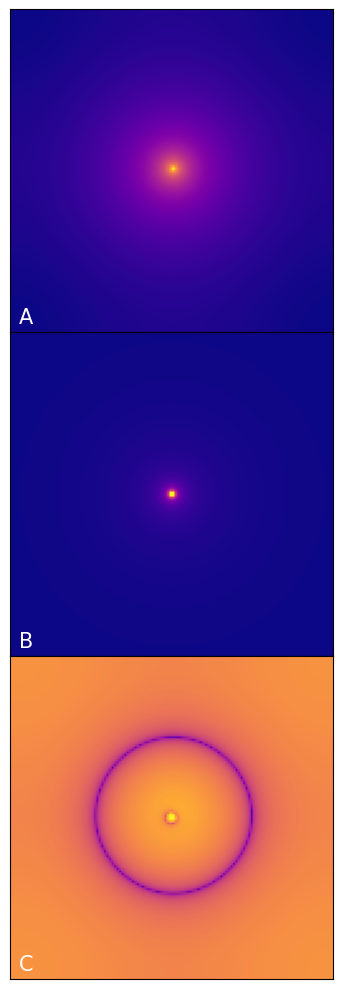

In [9]:
import string
from matplotlib.colors import LogNorm

N = 1         # number of particles
Nx = 128            # grid points in x direction
Ny = 128            # grid points in y direction
Lx = 10             # grid length in x direction
Ly = 10             # grid length in y direction
dx = Lx/Nx          # grid spacing in x direction
dy = Ly/Ny          # grid spacing in y direction
n0 = 1
pos = np.zeros((N,2))
pos[0,0] = 5
pos[0,1] = 5


#the acceleration function, modified to output charge density and electric potential for input particle positions 
def getAccel2(pos,Nx,Ny,Lx,Ly,n0,N):
    eps0 = 1
    dx = Lx/Nx
    dy = Ly/Ny
    j = np.zeros((N,2))
    jp1 = np.zeros((N,2))
    
    #define grid points
    j[:,0] = np.floor(pos[:,0]/dx).astype(int)
    j[:,1] = np.floor(pos[:,1]/dy).astype(int)
    jp1 = j + 1
    
    #calculate weights of particle on each grid point
    weight_jxjy = (jp1[:,0]*dx - pos[:,0])/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxp1jy = (pos[:,0] - j[:,0]*dx)/dx * (jp1[:,1]*dy - pos[:,1])/dy
    weight_jxjyp1 = (jp1[:,0]*dx - pos[:,0])/dx * (pos[:,1] - j[:,1]*dy)/dy
    weight_jxp1jyp1 = (pos[:,0] - j[:,0]*dx)/dx * (pos[:,1] - j[:,1]*dy)/dy
    
    #periodic boundary conditions:
    jp1[:,0] = np.mod(jp1[:,0], Nx)
    jp1[:,1] = np.mod(jp1[:,1], Ny)
    
    #smear the particle position across four nearest gridpoints, weighting by distance to each gridpoint 
    xbin = np.linspace(0, Nx, Nx+1)
    ybin = np.linspace(0, Ny, Ny+1)
    
    #count number of particles smeared to each grid point
    n = st.binned_statistic_2d(j[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j) grid point
    n += st.binned_statistic_2d(jp1[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j+1) grid point
    n += st.binned_statistic_2d(j[:,0], jp1[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j,j+1) grid point
    n += st.binned_statistic_2d(jp1[:,0], j[:,1], None, 'count', bins = [xbin,ybin], expand_binnumbers=True).statistic #(j+1,j) grid point
    
    #weight the contribution  of each particle to each grid point it has been smeared across
    n[j[:,0].astype(int),j[:,1].astype(int)] *= weight_jxjy
    n[jp1[:,0].astype(int),j[:,1].astype(int)] *= weight_jxp1jy
    n[j[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxjyp1
    n[jp1[:,0].astype(int),jp1[:,1].astype(int)] *= weight_jxp1jyp1
    
    rho = n0*n/(dx*dy)
    
    #calculate electric potential at each grid point
    phi_grid = phi_compute(rho,eps0,Nx,Ny,dx,dy)
    
    #calculate electric field from electric potential
    Ex = -np.gradient(phi_grid, dx, axis = 0)
    Ey = -np.gradient(phi_grid, dy, axis = 1)
    E = np.zeros((N,2))
    j = j.astype(int)
    jp1 = jp1.astype(int)
    
    #interpolate electric field at each particle position
    E[:,0] = Ex[j[:,0],j[:,1]]*weight_jxjy + Ex[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ex[jp1[:,0],j[:,1]]*weight_jxp1jy + Ex[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    E[:,1] = Ey[j[:,0],j[:,1]]*weight_jxjy + Ey[j[:,0],jp1[:,1]]*weight_jxjyp1 + Ey[jp1[:,0],j[:,1]]*weight_jxp1jy + Ey[jp1[:,0],jp1[:,1]]*weight_jxp1jyp1
    a = -E
    
    return n, rho, phi_grid

#electric potential of point charge from analytic 1/r equation
def phi_analytic(x,y):
    phi = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            phi[i,j] = -1/np.sqrt((x[i]-5)**2 + (y[j]-5)**2)
    phi /= (4*np.pi)
    return phi

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
phi_analytic = phi_analytic(x,y)

#output particle position smeared to grid n, charge density rho, and electric field phi_grid calculated using FFT applied
#to the particle positions input into getAccel2
n, rho, phi_grid = getAccel2(pos,Nx,Ny,Lx,Ly,n0,N)

%matplotlib inline

#plot three colour maps, first showing the potential calculated with FFT, the second the anaylitic potential
#the third the difference between the two potentials.
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].imshow(phi_grid, origin = 'lower', cmap = 'plasma_r')
axs[1].imshow(phi_analytic, origin = 'lower', cmap = 'plasma_r')
axs[2].imshow(np.abs(phi_analytic-phi_grid), origin = 'lower', cmap = 'plasma', norm = LogNorm())
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

for index, ax in enumerate(axs):
    ax.text(3, 3, string.ascii_uppercase[index],size=15, color = 'white')
    
plt.tight_layout()
#plt.savefig('potential_compare.png',dpi=600)



The above plot shows in A the electric potential computed using the FFT method on a single particle-in-cell. B shows the analytic 1/r potential of a single point particle. C shows the difference between these two plots.